# Isolation Forest ⭐⭐⭐



### Overview
Isolation Forest is one of the most widely deployed anomaly detection algorithms in production systems. Unlike traditional methods that profile normal data, it explicitly isolates anomalies by exploiting their fundamental property: **anomalies are few and different**. This makes them easier to isolate through random partitioning.

### Core Concept: How It Works

The algorithm works on a simple but powerful principle:
- **Anomalies are rare**: They appear less frequently than normal points
- **Anomalies are different**: They have attribute values that are very different from normal instances
- **Result**: Anomalies are easier to isolate and require fewer partitions to separate from the rest of the data

Think of it like this: If you're trying to isolate a single tall person in a crowd of average-height people, you can quickly separate them with just a few height-based splits. But isolating an average-height person requires many more splits because they're surrounded by similar individuals.

### The Algorithm

**Training Phase:**
1. Randomly select a subset of data (sample size: 256 is typical)
2. Randomly select a feature
3. Randomly select a split value between min and max of that feature
4. Partition data into two groups based on the split
5. Recursively repeat until:
   - Each point is isolated, OR
   - Maximum tree depth is reached
6. Build multiple trees (ensemble, typically 100 trees)

**Scoring Phase:**
For each data point, measure the average path length (number of splits) needed to isolate it across all trees:
- **Short path** = Easy to isolate = **Anomaly**
- **Long path** = Hard to isolate = **Normal**

### Mathematical Foundation

**Anomaly Score:**
```
s(x, n) = 2^(-E(h(x)) / c(n))
```

Where:
- `h(x)` = path length for point x
- `E(h(x))` = average path length across all trees
- `c(n)` = average path length of unsuccessful search in Binary Search Tree (normalization factor)
- `n` = number of training samples

**Interpretation:**
- Score close to **1**: Clear anomaly
- Score close to **0.5**: Normal instance
- Score close to **0**: Very normal instance

### Key Hyperparameters

**1. contamination** (default: 'auto')
- Expected proportion of outliers in the dataset
- Typical range: 0.01 to 0.1 (1% to 10%)
- Used to set the decision threshold
- **For cost data**: Start with 0.05 (5% anomalies)

**2. n_estimators** (default: 100)
- Number of trees in the ensemble
- More trees = more stable results but slower
- Typical range: 50 to 200
- **Recommendation**: 100 is usually sufficient

**3. max_samples** (default: 'auto' or 256)
- Number of samples to draw for each tree
- Smaller = faster, potentially less accurate
- Larger = slower, more accurate
- **Default 256** works well in most cases

**4. max_features** (default: 1.0)
- Number of features to consider for splitting
- 1.0 = use all features
- Can use fewer for high-dimensional data
- **For cost data with 5-20 features**: Use 1.0

**5. random_state**
- Controls randomness for reproducibility
- Always set in production for consistency

### Why Isolation Forest Excels

✅ **Advantages:**
1. **Fast and scalable**: O(n log n) complexity
2. **Works with high-dimensional data**: No distance calculations needed
3. **No assumptions about data distribution**: Doesn't assume normality
4. **Handles mixed data types**: Numerical features work directly
5. **Low memory footprint**: Uses subsampling (256 samples per tree)
6. **Robust to irrelevant features**: Random feature selection
7. **No need for labeled data**: Fully unsupervised
8. **Easy to interpret**: Path length has intuitive meaning

❌ **Limitations:**
1. **Struggles with local anomalies**: Global detector, doesn't consider density variations
2. **Can miss clustered anomalies**: If anomalies form their own cluster
3. **Feature importance unclear**: Random splits make interpretation harder
4. **Sensitive to contamination parameter**: Requires tuning
5. **Not optimal for very high dimensions**: (100+ features) - consider PCA first

### When Isolation Forest Excels vs When It Fails

**✅ Excels:**
- **Point anomalies**: Individual unusual records (fraudulent transactions, equipment failures)
- **Global anomalies**: Clearly different from all normal data
- **High-dimensional data**: Many features (10-50+)
- **Large datasets**: Millions of records
- **Skewed cost distributions**: Naturally handles skewness
- **Real-time scoring**: Fast inference for production

**❌ Fails or Underperforms:**
- **Local/contextual anomalies**: Point normal globally but anomalous locally (use LOF instead)
- **Collective anomalies**: Sequential patterns (use time series methods)
- **Very small datasets**: < 100 samples (use statistical methods)
- **Anomaly clusters**: Multiple anomalies with similar patterns
- **When relationships matter**: Correlation-based anomalies (use Mahalanobis)

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# Generate sample multivariate cost data
np.random.seed(42)
n_samples = 1000

# Normal costs
labor_cost = np.random.normal(50000, 10000, n_samples)
material_cost = np.random.normal(30000, 5000, n_samples)
overhead = np.random.normal(20000, 3000, n_samples)

# Inject anomalies
n_anomalies = 50
anomaly_idx = np.random.choice(n_samples, n_anomalies, replace=False)
labor_cost[anomaly_idx] += np.random.choice([30000, -20000], n_anomalies)
material_cost[anomaly_idx] += np.random.choice([20000, -15000], n_anomalies)

# Create DataFrame
df = pd.DataFrame({
    'labor_cost': labor_cost,
    'material_cost': material_cost,
    'overhead': overhead
})

# Scale features (important for cost data with different magnitudes)
scaler = RobustScaler()  # Robust to outliers
X_scaled = scaler.fit_transform(df)

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,      # Expect 5% anomalies
    n_estimators=100,        # 100 trees
    max_samples='auto',      # 256 samples per tree
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

# Predict: -1 for anomalies, 1 for normal
df['prediction'] = iso_forest.fit_predict(X_scaled)

# Get anomaly scores (more negative = more anomalous)
df['anomaly_score'] = iso_forest.score_samples(X_scaled)

# Convert to interpretable scores (0 to 1)
df['anomaly_score_normalized'] = (1 - df['anomaly_score'].rank(pct=True))

# Identify anomalies
anomalies = df[df['prediction'] == -1]
normal = df[df['prediction'] == 1]

print(f"Total samples: {len(df)}")
print(f"Detected anomalies: {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)")
print(f"Normal instances: {len(normal)}")

Total samples: 1000
Detected anomalies: 50 (5.0%)
Normal instances: 950


In [2]:

### Implementation Example
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# Generate sample multivariate cost data
np.random.seed(42)
n_samples = 1000

# Normal costs
labor_cost = np.random.normal(50000, 10000, n_samples)
material_cost = np.random.normal(30000, 5000, n_samples)
overhead = np.random.normal(20000, 3000, n_samples)

# Inject anomalies
n_anomalies = 50
anomaly_idx = np.random.choice(n_samples, n_anomalies, replace=False)
labor_cost[anomaly_idx] += np.random.choice([30000, -20000], n_anomalies)
material_cost[anomaly_idx] += np.random.choice([20000, -15000], n_anomalies)

# Create DataFrame
df = pd.DataFrame({
    'labor_cost': labor_cost,
    'material_cost': material_cost,
    'overhead': overhead
})

# Scale features (important for cost data with different magnitudes)
scaler = RobustScaler()  # Robust to outliers
X_scaled = scaler.fit_transform(df)

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,      # Expect 5% anomalies
    n_estimators=100,        # 100 trees
    max_samples='auto',      # 256 samples per tree
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

# Predict: -1 for anomalies, 1 for normal
df['prediction'] = iso_forest.fit_predict(X_scaled)

# Get anomaly scores (more negative = more anomalous)
df['anomaly_score'] = iso_forest.score_samples(X_scaled)

# Convert to interpretable scores (0 to 1)
df['anomaly_score_normalized'] = (1 - df['anomaly_score'].rank(pct=True))

# Identify anomalies
anomalies = df[df['prediction'] == -1]
normal = df[df['prediction'] == 1]

print(f"Total samples: {len(df)}")
print(f"Detected anomalies: {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)")
print(f"Normal instances: {len(normal)}")

Total samples: 1000
Detected anomalies: 50 (5.0%)
Normal instances: 950


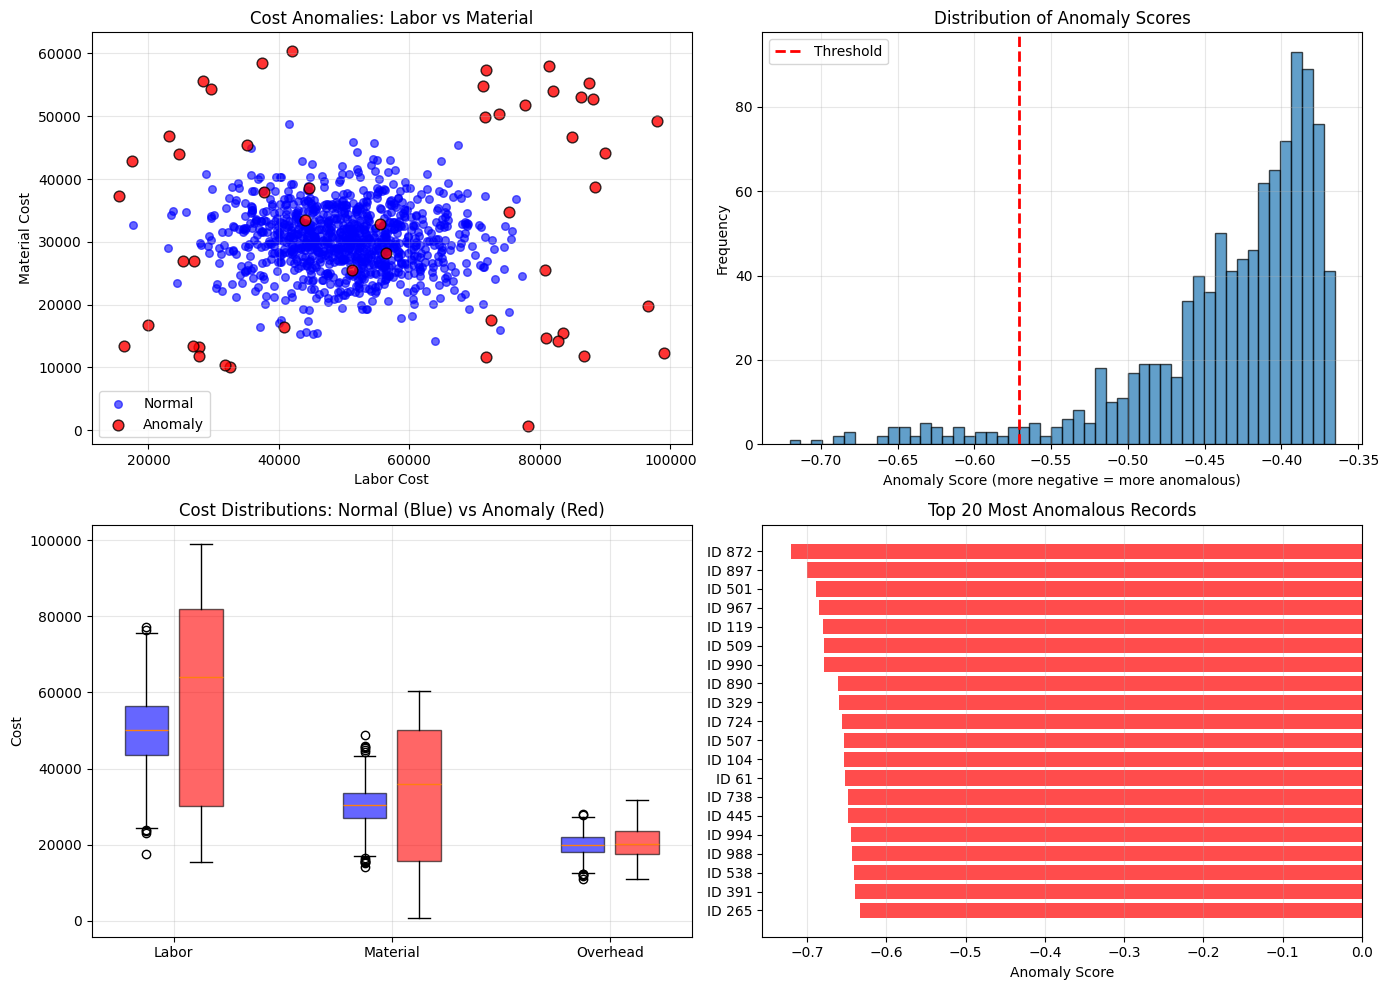

In [3]:

### Visualization of Results
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot: Labor vs Material Cost
ax1 = axes[0, 0]
ax1.scatter(normal['labor_cost'], normal['material_cost'],
           c='blue', alpha=0.6, s=30, label='Normal')
ax1.scatter(anomalies['labor_cost'], anomalies['material_cost'],
           c='red', alpha=0.8, s=60, label='Anomaly', edgecolors='black')
ax1.set_xlabel('Labor Cost')
ax1.set_ylabel('Material Cost')
ax1.set_title('Cost Anomalies: Labor vs Material')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Anomaly Score Distribution
ax2 = axes[0, 1]
ax2.hist(df['anomaly_score'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=df[df['prediction'] == -1]['anomaly_score'].max(),
           color='red', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('Anomaly Score (more negative = more anomalous)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Anomaly Scores')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Box plots for each cost component
ax3 = axes[1, 0]
box_data = [normal['labor_cost'], anomalies['labor_cost'],
           normal['material_cost'], anomalies['material_cost'],
           normal['overhead'], anomalies['overhead']]
positions = [1, 1.5, 3, 3.5, 5, 5.5]
colors = ['blue', 'red', 'blue', 'red', 'blue', 'red']
bp = ax3.boxplot(box_data, positions=positions, widths=0.4, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax3.set_xticks([1.25, 3.25, 5.25])
ax3.set_xticklabels(['Labor', 'Material', 'Overhead'])
ax3.set_ylabel('Cost')
ax3.set_title('Cost Distributions: Normal (Blue) vs Anomaly (Red)')
ax3.grid(alpha=0.3)

# 4. Top anomalies by score
ax4 = axes[1, 1]
top_anomalies = df.nsmallest(20, 'anomaly_score')
y_pos = np.arange(len(top_anomalies))
ax4.barh(y_pos, top_anomalies['anomaly_score'], color='red', alpha=0.7)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([f"ID {idx}" for idx in top_anomalies.index])
ax4.set_xlabel('Anomaly Score')
ax4.set_title('Top 20 Most Anomalous Records')
ax4.invert_yaxis()
ax4.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [4]:

# While Isolation Forest doesn't provide direct feature importance,
# we can estimate which features contributed most to anomalies

def analyze_anomaly_features(df, anomalies, normal):
    """Compare feature statistics between anomalies and normal data"""

    features = ['labor_cost', 'material_cost', 'overhead']

    print("\nFeature Analysis: Anomalies vs Normal")
    print("=" * 60)

    for feature in features:
        anom_mean = anomalies[feature].mean()
        norm_mean = normal[feature].mean()
        diff_pct = ((anom_mean - norm_mean) / norm_mean) * 100

        print(f"\n{feature.upper()}:")
        print(f"  Normal mean:   ${norm_mean:,.0f}")
        print(f"  Anomaly mean:  ${anom_mean:,.0f}")
        print(f"  Difference:    {diff_pct:+.1f}%")
        print(f"  Normal std:    ${normal[feature].std():,.0f}")
        print(f"  Anomaly std:   ${anomalies[feature].std():,.0f}")

analyze_anomaly_features(df, anomalies, normal)


Feature Analysis: Anomalies vs Normal

LABOR_COST:
  Normal mean:   $50,172
  Anomaly mean:  $57,600
  Difference:    +14.8%
  Normal std:    $9,726
  Anomaly std:   $27,009

MATERIAL_COST:
  Normal mean:   $30,336
  Anomaly mean:  $33,905
  Difference:    +11.8%
  Normal std:    $5,135
  Anomaly std:   $17,555

OVERHEAD:
  Normal mean:   $19,976
  Anomaly mean:  $20,798
  Difference:    +4.1%
  Normal std:    $2,830
  Anomaly std:   $4,663



Hyperparameter Tuning Results:
   contamination  n_anomalies  avg_anomaly_score
0           0.01           10          -0.680620
1           0.03           30          -0.650637
2           0.05           50          -0.626333
3           0.07           70          -0.604731
4           0.10          100          -0.579886


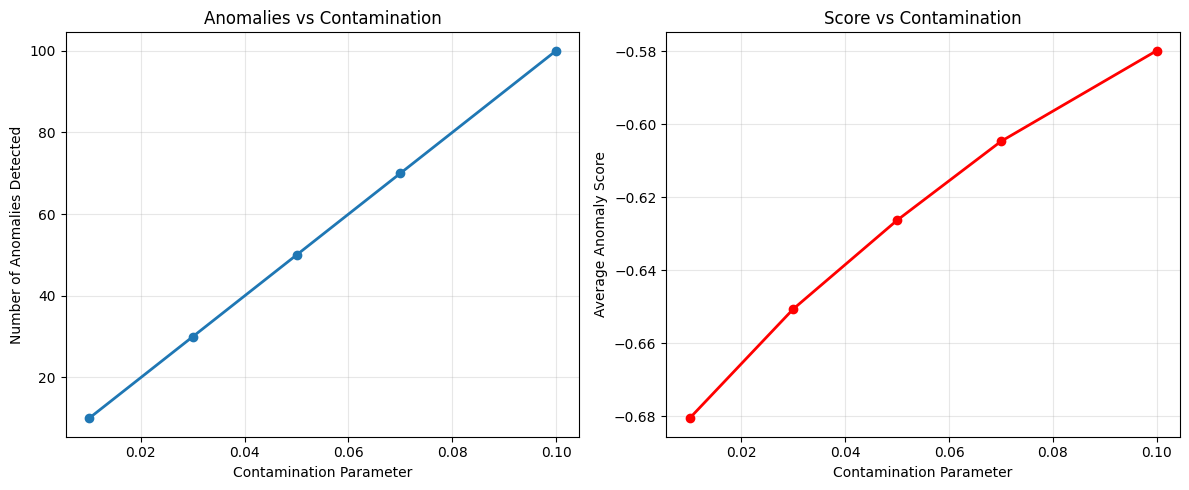

In [5]:

### Hyperparameter Tuning
from sklearn.metrics import silhouette_score

def tune_isolation_forest(X, contamination_range):
    """Find optimal contamination parameter"""

    results = []

    for contam in contamination_range:
        iso = IsolationForest(
            contamination=contam,
            n_estimators=100,
            random_state=42
        )
        labels = iso.fit_predict(X)
        scores = iso.score_samples(X)

        # Calculate metrics
        n_anomalies = (labels == -1).sum()
        avg_score = scores[labels == -1].mean()

        results.append({
            'contamination': contam,
            'n_anomalies': n_anomalies,
            'avg_anomaly_score': avg_score
        })

    return pd.DataFrame(results)

# Test different contamination values
contamination_range = [0.01, 0.03, 0.05, 0.07, 0.10]
tuning_results = tune_isolation_forest(X_scaled, contamination_range)

print("\nHyperparameter Tuning Results:")
print(tuning_results)

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tuning_results['contamination'], tuning_results['n_anomalies'],
         marker='o', linewidth=2)
plt.xlabel('Contamination Parameter')
plt.ylabel('Number of Anomalies Detected')
plt.title('Anomalies vs Contamination')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(tuning_results['contamination'], tuning_results['avg_anomaly_score'],
         marker='o', linewidth=2, color='red')
plt.xlabel('Contamination Parameter')
plt.ylabel('Average Anomaly Score')
plt.title('Score vs Contamination')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# 3. Model Monitoring**
# Track model performance over time
def monitor_model_drift(iso_forest, new_data_scaled):
    scores = iso_forest.score_samples(new_data_scaled)

    metrics = {
        'mean_score': scores.mean(),
        'std_score': scores.std(),
        'anomaly_rate': (iso_forest.predict(new_data_scaled) == -1).mean(),
        'score_p95': np.percentile(scores, 5)  # More negative = more anomalous
    }

    return metrics


### Integration with Cost Analysis Workflows

**Typical Production Workflow:**

1. **Data Ingestion**: Collect cost data from ERP/accounting systems
2. **Preprocessing**:
   - Handle missing values
   - Log transform skewed features
   - Robust scaling
3. **Anomaly Detection**: Run Isolation Forest
4. **Prioritization**: Rank anomalies by score
5. **Business Rule Filters**: Apply domain-specific rules
6. **Alert Generation**: Flag high-priority anomalies
7. **Visual Dashboard**: Present results to finance team
8. **Investigation**: Domain experts review flagged costs
9. **Feedback Loop**: Update model with validated labels

### Best Practices for Cost Anomaly Detection

✅ **Do:**
- Use **RobustScaler** or **log transformation** for skewed cost data
- Set **contamination** based on historical anomaly rates
- **Visualize results** before deploying to production
- Combine with **business rules** (e.g., costs > $X always flagged)
- **Monitor model drift** - retrain quarterly or when data distribution shifts
- Provide **top-K anomalies** rather than binary flags
- Include **anomaly scores** in alerts for prioritization

❌ **Don't:**
- Use StandardScaler with highly skewed cost data
- Set contamination too high (> 0.10) - reduces sensitivity
- Rely solely on algorithm - always validate with domain experts
- Ignore temporal patterns - consider time series methods if costs have trends
- Deploy without A/B testing against current process

### Real-World Use Cases

**1. Procurement Fraud Detection**
- Detect unusually high purchase orders
- Identify vendor payment anomalies
- Flag suspicious expense claims

**2. Budget Variance Analysis**
- Spot departments exceeding budgets
- Identify cost overruns early
- Monitor project expenses

**3. Manufacturing Cost Control**
- Detect material wastage
- Identify inefficient production runs
- Monitor energy consumption anomalies

**4. Healthcare Cost Management**
- Flag unusual treatment costs
- Detect billing errors
- Identify cost inefficiencies

### Comparison with Alternative Methods

| Method | Speed | Interpretability | Handles Skewness | Local Anomalies | Best For |
|--------|-------|------------------|------------------|-----------------|----------|
| **Isolation Forest** | ⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐ | ❌ | Global anomalies, large datasets |
| LOF | ⭐⭐ | ⭐⭐ | ⭐⭐ | ⭐⭐⭐ | Local/contextual anomalies |
| One-Class SVM | ⭐ | ⭐ | ⭐⭐ | ⭐⭐ | Clean baseline data |
| Statistical (Z-score) | ⭐⭐⭐ | ⭐⭐⭐ | ❌ | ❌ | Normal distributions |
| DBSCAN | ⭐⭐ | ⭐⭐ | ⭐⭐ | ⭐⭐⭐ | Clustered data |

### Further Reading

- **Original Paper**: "Isolation Forest" by Liu, Ting, and Zhou (2008)
- **scikit-learn Documentation**: Isolation Forest API
- **PyOD Library**: Extended implementation with additional features
- **Production Examples**: AWS, Azure, and Google Cloud all use variants

### Summary

Isolation Forest is the **go-to algorithm** for cost anomaly detection because:
- It's **fast** enough for production at scale
- It **handles skewed distributions** naturally (common in cost data)
- It requires **minimal tuning** (mainly just contamination parameter)
- It's **interpretable** enough for finance teams (path length = isolation difficulty)
- It's **proven in production** (widely deployed across industries)

The key is proper preprocessing (robust scaling, handling skewness) and combining it with domain knowledge and visualization for validation.